# Segment Anything Model (SAM)
Research by Meta AI

https://segment-anything.com/
> SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training.

https://github.com/facebookresearch/segment-anything

> The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks.

In [3]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
import torch
import cv2

In [4]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-aiygfhih
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-aiygfhih
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36621 sha256=2a72b73bddddab04960df70344039b3a2911c1ecd414b4abf2990300c6b47d44
  Stored in directory: /tmp/pip-ephem-wheel-cache-pz723kto/wheels/6e/b2/38/082465c177a067501384fd15cb18be1128372ef60f27a1c426
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


In [5]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

# Automatically Generating Object Masks with SAM

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

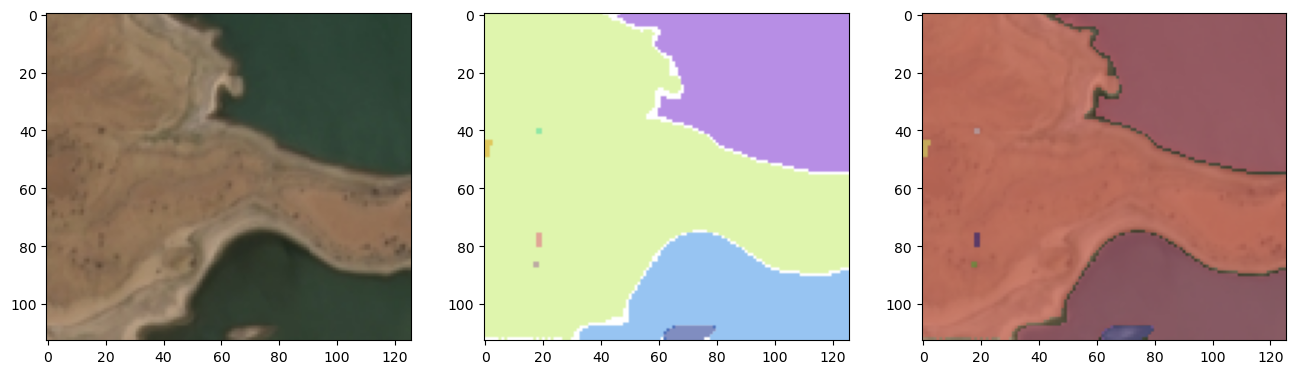

In [17]:
image_path = '/kaggle/input/rgb-images-test/R051_Taourirt_B02_B03_B04_B08_5.jpg'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image_array)

_, axes = plt.subplots(1,3, figsize=(16,16))
axes[0].imshow(image_array)
show_anns(masks, axes[1])
axes[2].imshow(image_array)
show_anns(masks, axes[2])

In [10]:
del(mask_generator)

# Object masks from prompts with SAM

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

In [11]:
from segment_anything import sam_model_registry, SamPredictor

predictor = SamPredictor(sam)

# Selecting objects with SAM


## Specifying a specific object with points

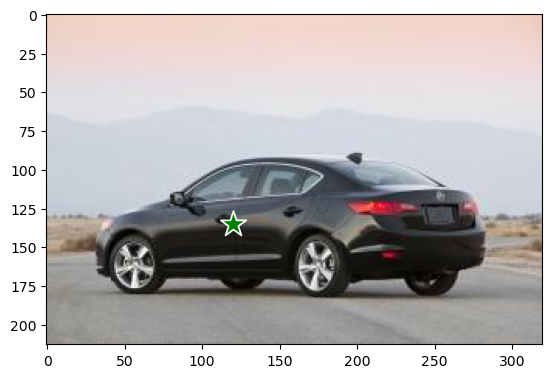

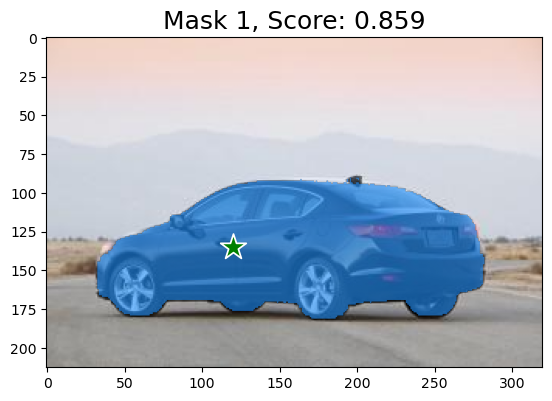

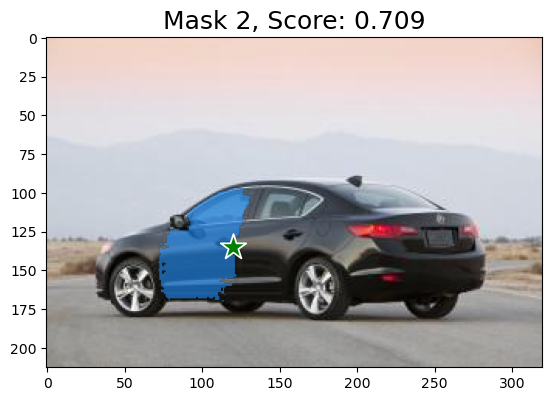

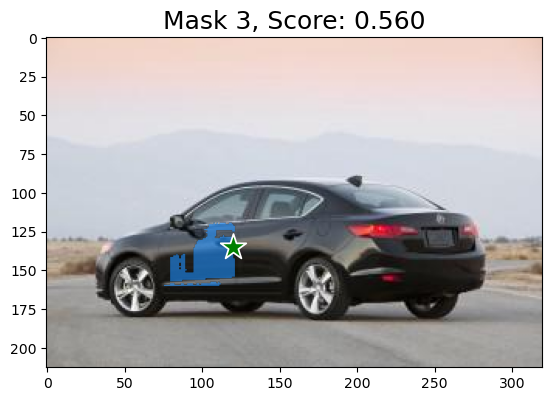

In [12]:
image_path = '/kaggle/input/the-car-connection-picture-dataset/Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Klc.jpg'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[120, 135]])
input_label = np.array([1])

plt.imshow(image_array)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  



masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
    plt.imshow(image_array)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()  
  

## Specifying a specific object with additional points (include and exclude)

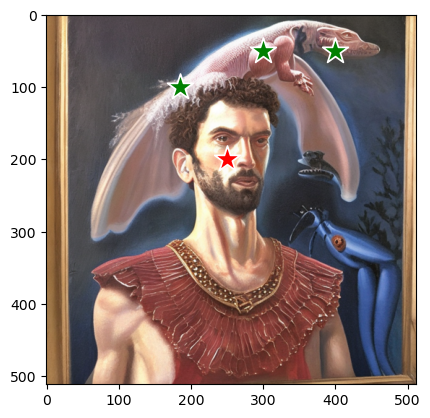

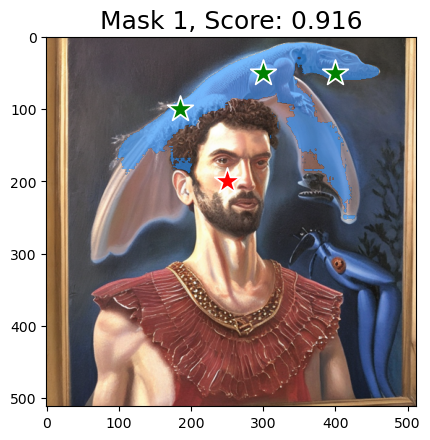

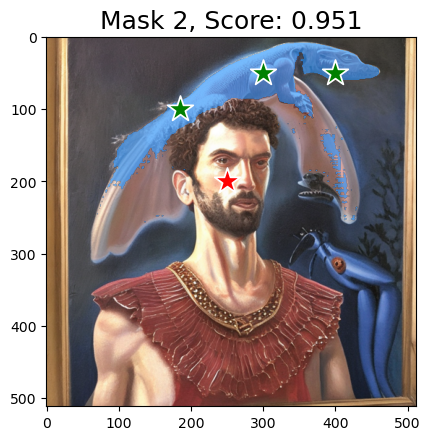

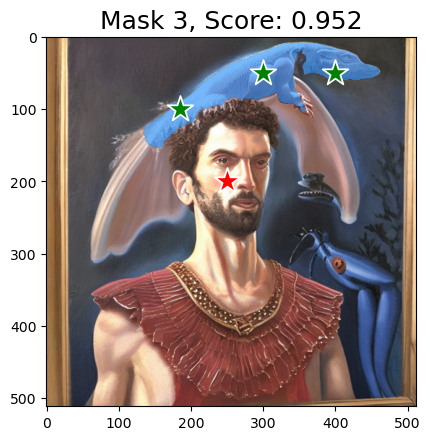

In [13]:
image_path = '/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[300, 50], [185, 100], [250, 200], [400, 50]])
input_label = np.array([1, 1, 0, 1])

plt.imshow(image_array)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  



masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
    plt.imshow(image_array)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()  

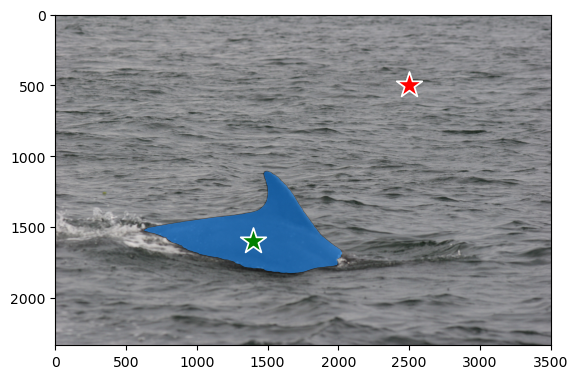

In [14]:
image_path = '/kaggle/input/happy-whale-and-dolphin/train_images/00177f3c614d1e.jpg'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[1400, 1600], [2500, 500]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.imshow(image_array)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()   

## Specifying a specific object with a box


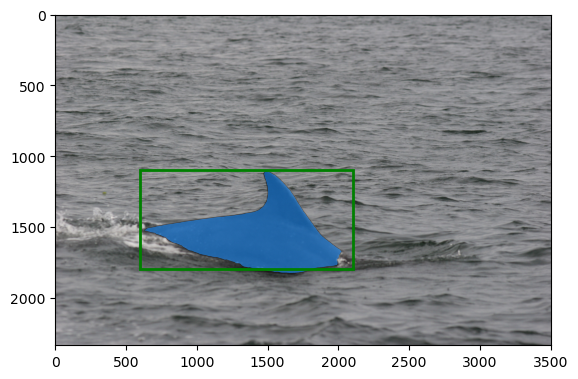

In [15]:
input_box = np.array([600, 1100, 2100, 1800])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)
plt.imshow(image_array)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.show()

Follow this notebook for additional prompting options:

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb